In [16]:

import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')

In [17]:
os.listdir()

filled_files = [file for file in os.listdir() if file.endswith("_filled.csv")]

filled_files

[]

In [18]:




# Reading the data from the appropriate CSV files

housing_units = pd.read_csv('HousingPrices/data/housing_units_filled.csv')
consumer_sentiment = pd.read_csv('HousingPrices/data/consumer_sentiment_filled.csv')
ppi_building = pd.read_csv('HousingPrices/data/ppi_building_filled.csv')
mortgage_rate = pd.read_csv('HousingPrices/data/Mortgage_rate_filled.csv')
target_var = pd.read_csv('HousingPrices/data/target_filled.csv')
ppi_trans = pd.read_csv('HousingPrices/data/ppi_trans_filled.csv')
newly_owned_houses = pd.read_csv('HousingPrices/data/new_owned_housing_units_filled.csv')
working_age_pop = pd.read_csv('HousingPrices/data/working_age_pop_filled.csv')
unemp_rate = pd.read_csv('HousingPrices/data/unemp_rate_filled.csv')
pop_growth = pd.read_csv('HousingPrices/data/pop_growth_filled.csv')
gdp_data = pd.read_csv('HousingPrices/data/gdp_data_filled.csv')

dataframes = [
    housing_units,
    consumer_sentiment,
    ppi_building,
    mortgage_rate,
    ppi_trans,
    newly_owned_houses,
    working_age_pop,
    unemp_rate,
    pop_growth,
    gdp_data,
    target_var
]

for i in dataframes:
    if 'Unnamed: 0' in i.columns:
        del i['Unnamed: 0']
    else:
        continue


In [19]:

# Renaming the columns from the column names provided by the data provider to something more meaningful

dataframes = {
    'housing_units': housing_units,
    'consumer_sentiment': consumer_sentiment,
    'ppi_building': ppi_building,
    'mortgage_rate': mortgage_rate,
    'ppi_trans': ppi_trans,
    'newly_owned_houses': newly_owned_houses,
    'working_age_pop': working_age_pop,
    'unemp_rate': unemp_rate,
    'pop_growth': pop_growth,
    'gdp_data': gdp_data,
    'target_var': target_var
}


In [20]:

for var_name, df in dataframes.items():
    for column in df.columns:
        # print(column)
        if column == 'Date':
            df.rename(columns={column: "DATE"}, inplace=True)
        if column.lower() != 'date':
            df.rename(columns={column: var_name}, inplace=True)

for i in dataframes.values():
    print(f'{i.columns} , {len(i)}')




Index(['DATE', 'housing_units'], dtype='object') , 252
Index(['DATE', 'consumer_sentiment'], dtype='object') , 252
Index(['DATE', 'ppi_building'], dtype='object') , 252
Index(['DATE', 'mortgage_rate'], dtype='object') , 260
Index(['DATE', 'ppi_trans'], dtype='object') , 252
Index(['DATE', 'newly_owned_houses'], dtype='object') , 260
Index(['DATE', 'working_age_pop'], dtype='object') , 241
Index(['DATE', 'unemp_rate'], dtype='object') , 252
Index(['DATE', 'pop_growth'], dtype='object') , 241
Index(['DATE', 'gdp_data'], dtype='object') , 252
Index(['DATE', 'target_var'], dtype='object') , 252


In [21]:
# dataframes

In [22]:
# Combining all the individual dataframes into a single dataframe
merged_df = dataframes[list(dataframes.keys())[0]]

for key, df in list(dataframes.items())[1:]:
    merged_df = pd.merge(merged_df, df, on=list(df.columns)[0], how='inner')

feature_columns = [col for col in merged_df.columns if col != 'DATE']
merged_df = merged_df[['DATE'] + feature_columns]

merged_df['DATE'] = pd.to_datetime(merged_df['DATE'])
merged_df['Year'] = merged_df['DATE'].dt.year
merged_df['Month'] = merged_df['DATE'].dt.month

# No Null values are observed as we had taken care of them during the pre-processing stage
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 241 entries, 0 to 240
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   DATE                241 non-null    datetime64[ns]
 1   housing_units       241 non-null    float64       
 2   consumer_sentiment  241 non-null    float64       
 3   ppi_building        241 non-null    float64       
 4   mortgage_rate       241 non-null    float64       
 5   ppi_trans           241 non-null    float64       
 6   newly_owned_houses  241 non-null    float64       
 7   working_age_pop     241 non-null    float64       
 8   unemp_rate          241 non-null    float64       
 9   pop_growth          241 non-null    float64       
 10  gdp_data            241 non-null    float64       
 11  target_var          241 non-null    float64       
 12  Year                241 non-null    int64         
 13  Month               241 non-null    int64         

In [23]:
merged_df.loc[200:205]

,DATE,housing_units,consumer_sentiment,ppi_building,mortgage_rate,ppi_trans,newly_owned_houses,working_age_pop,unemp_rate,pop_growth,gdp_data,target_var,Year,Month
200,2018-09-01,138681.333333,100.1,151.5,3.7,134.5,1250.0,2.065078e+08,3.7,0.526435,18722.410000,204.389,2018,9
201,2018-10-01,138778.000000,98.6,152.2,3.8,136.1,1221.0,2.065078e+08,3.8,0.526435,18733.741000,205.159,2018,10
202,2018-11-01,138875.000000,97.5,149.8,3.8,136.7,1181.0,2.065078e+08,3.8,0.526435,18767.631000,205.692,2018,11
203,2018-12-01,138972.000000,98.3,151.0,3.9,136.3,1095.0,2.065078e+08,3.9,0.526435,18801.521000,206.149,2018,12
204,2019-01-01,139069.000000,91.2,148.1,4.0,137.2,1232.0,2.062699e+08,4.0,0.455381,18835.411000,206.495,2019,1
205,2019-02-01,139166.000000,93.8,148.4,3.8,136.4,1128.0,2.062699e+08,3.8,0.455381,18877.665667,206.792,2019,2


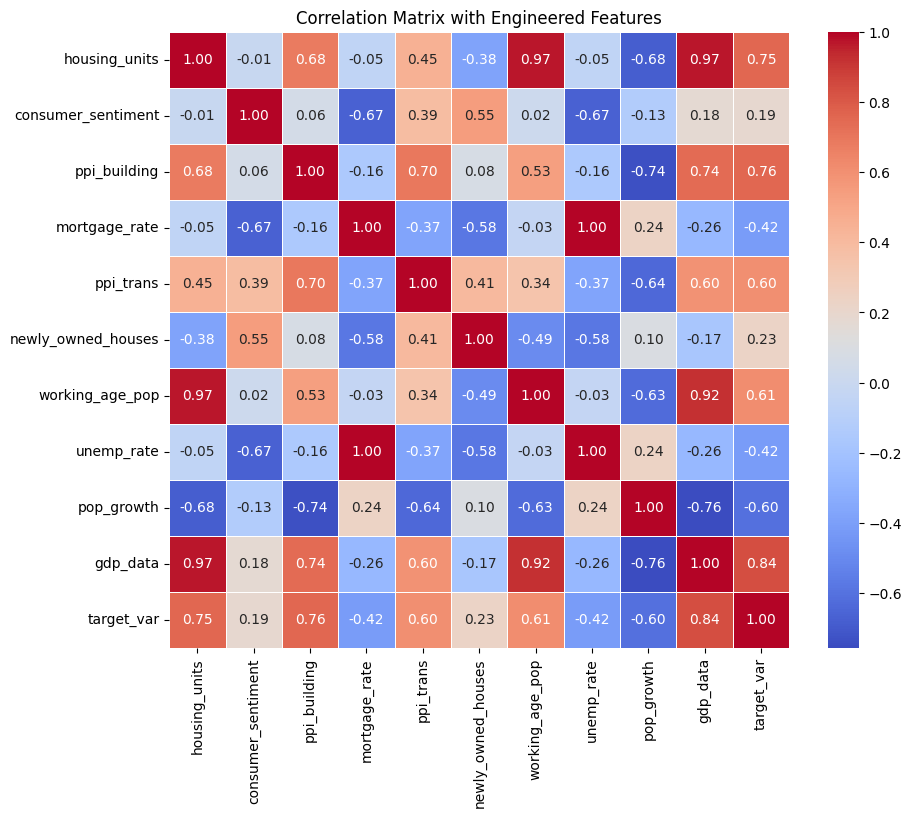

In [24]:

# As the columns "Date, Year, and Month" are not essential as features in the process of modeling the data,
# we create a new dataframe whose columns do not contain these columns
df1 = merged_df.iloc[:, ~merged_df.columns.isin(['DATE', 'Year', 'Month'])]

# df1['target_rolling_mean'] = df1['target_var'].rolling(window=3).mean()

# # Adding a new feature: Difference between the target variable and its lag
# df1['target_diff'] = df1['target_var'] - df1['target_var'].shift(1)

# # Adding a new feature: Lag of the target variable
# df1['target_lag'] = df1['target_var'].shift(1)

# # Drop rows with NaN values created by the rolling mean and lag
# df1 = df1.dropna()

# Using Seaborn's heatmap plot, we plot the correlation matrix of the features
plt.figure(figsize=(10, 8))
sns.heatmap(df1.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix with Engineered Features")
plt.show()

# The Dataframe stored in the variable "X" will be used as the training dataset consisting of the feature variables.
# The variable "Y" holds the target variable which consists of the "S&P Case-Schiller Home Price Index"
X = df1.iloc[:, ~df1.columns.isin(['DATE', 'Year', 'Month'])]
Y = X['target_var']

In [25]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


mm = MinMaxScaler()

for i in X.columns:
    X[i] = mm.fit_transform(X[[i]])

for column_name in X.columns:
    if X[column_name].dtype == 'float64':
        mean_value = X[X[column_name] != 0][column_name].mean()
        X[column_name] = X[column_name].replace(0, mean_value)

# In the following block of code, we are determining outliers present in each column
# as the values that either exceed "upper quantile + IQR" or fall below "lower quantile - IQR".
# These values are then replaced by the upper and lower bound values respectively.
lower_quantile = 0.25
upper_quantile = 0.75

IQR = X.quantile(upper_quantile) - X.quantile(lower_quantile)

for column_name in X.columns:
    if X[column_name].dtype == 'float64':
        lower_bound = X[column_name].quantile(lower_quantile) - 1.5 * IQR[column_name]
        upper_bound = X[column_name].quantile(upper_quantile) + 1.5 * IQR[column_name]
        X[column_name] = X[column_name].clip(lower=lower_bound, upper=upper_bound)

# We split the data into training / testing sets using a 0.2 ratio where 0.2 % of the samples present will be used as the test set
# and the remaining for training.
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=1)

print(f'{xtrain.shape} , {ytrain.shape} , {xtest.shape} , {ytest.shape}')





(192, 11) , (192,) , (49, 11) , (49,)


In [26]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2]
}

xgb_model = XGBRegressor()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(xtrain, ytrain)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with the best parameters
best_xgb_model = XGBRegressor(**best_params)
best_xgb_model.fit(xtrain, ytrain)
ypred = best_xgb_model.predict(xtest)


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}


In [27]:
print(f' R2 Score is : {r2_score(ytest , ypred)} \n Mean Squared Error is : {mean_squared_error(ytest , ypred)}')

 R2 Score is : 0.9977628388900563 
 Mean Squared Error is : 3.221665602627993


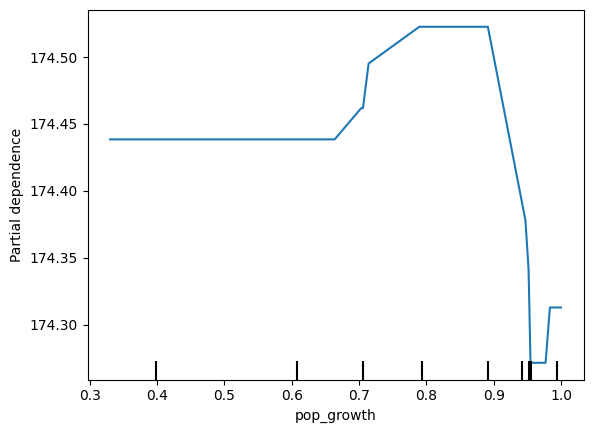

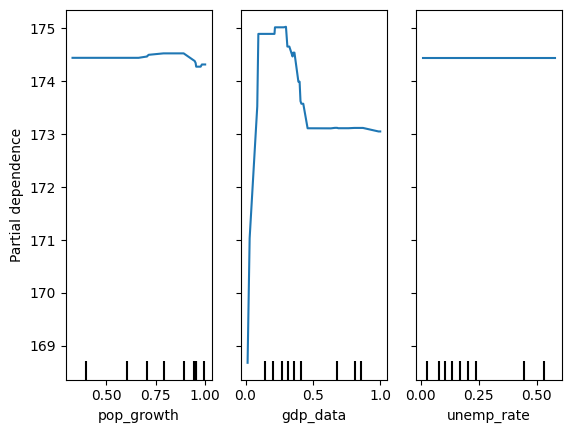

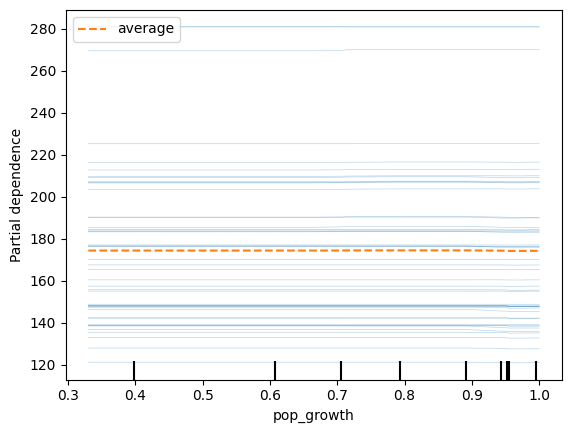

In [28]:
import pandas as pd
from sklearn.inspection import PartialDependenceDisplay

# # Create test data  
# xtest = pd.DataFrame(xtest)  
# y_test = pd.Series(ytest)

# Generate PDP for pop_growth
pdp_pop_growth = PartialDependenceDisplay.from_estimator(
    best_xgb_model, xtest, features=['pop_growth'])
pdp_pop_growth.figure_.show()

# Generate PDP for multiple features 
features_to_plot = ['pop_growth', 'gdp_data', 'unemp_rate']
inter1 = PartialDependenceDisplay.from_estimator(
    best_xgb_model, xtest, features=features_to_plot)
inter1.figure_.show()

# Create PDP plot with multiple lines
lines_pop_growth = PartialDependenceDisplay.from_estimator(
    best_xgb_model, xtest, features=['pop_growth'], kind="both")
lines_pop_growth.figure_.show()

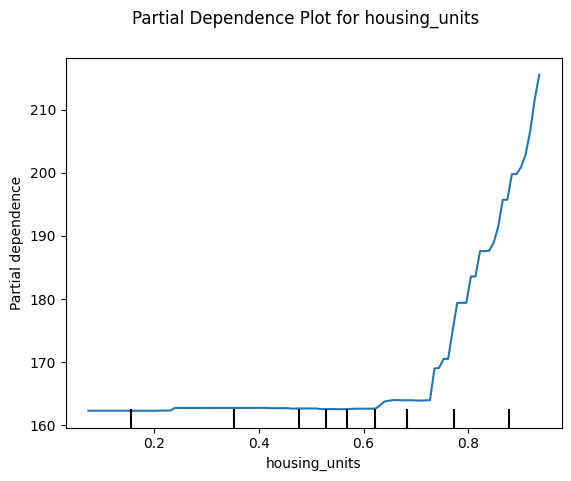

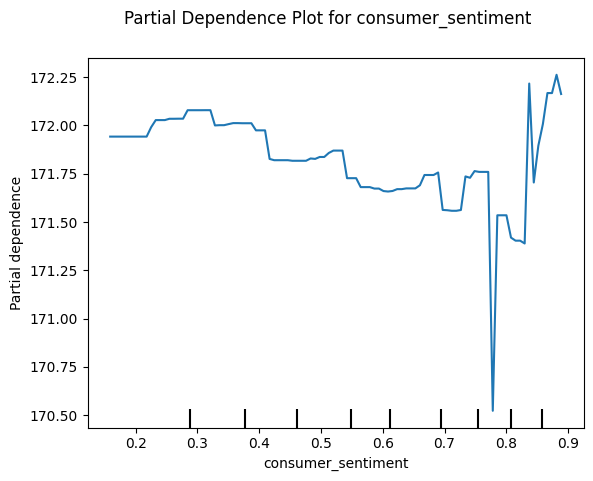

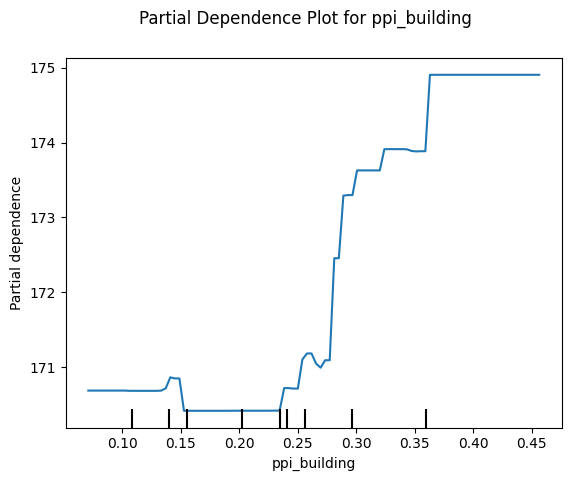

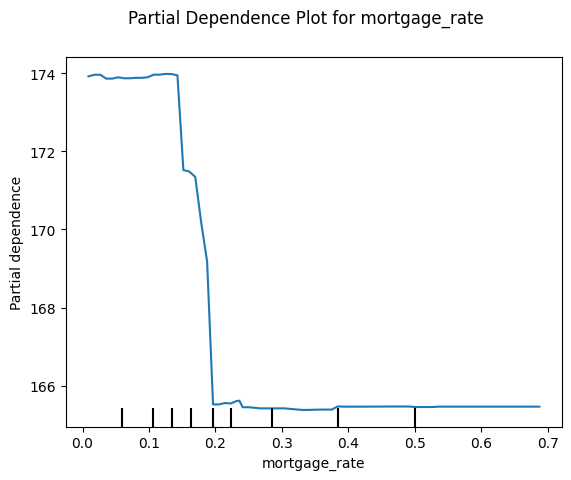

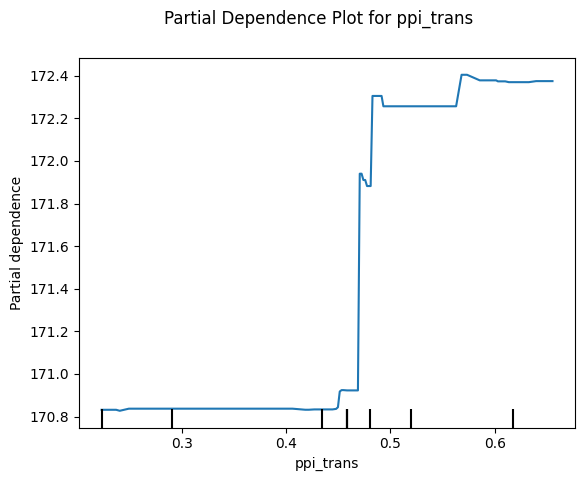

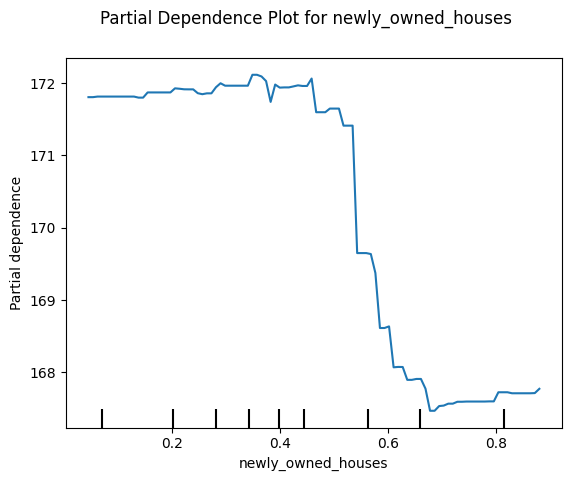

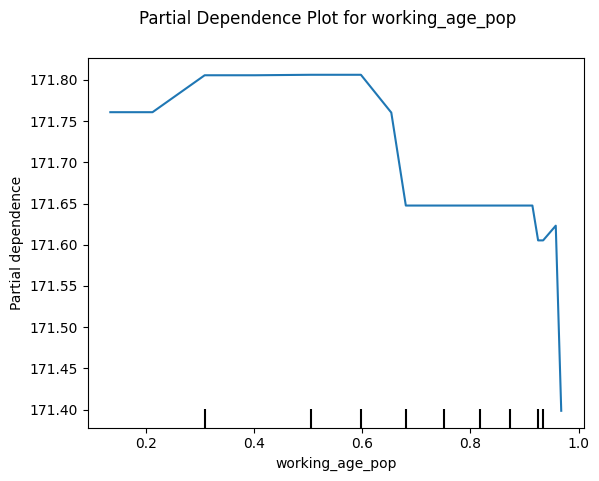

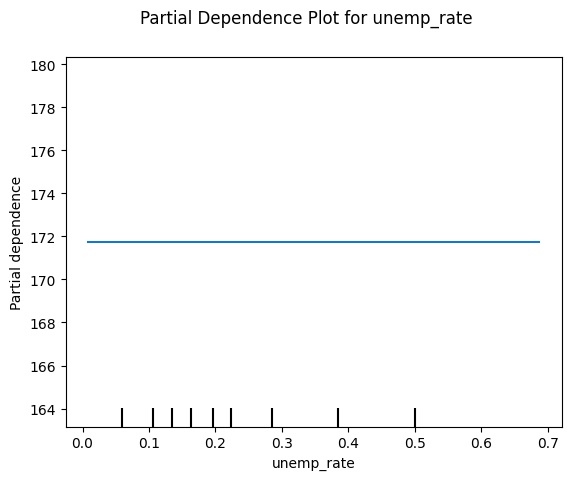

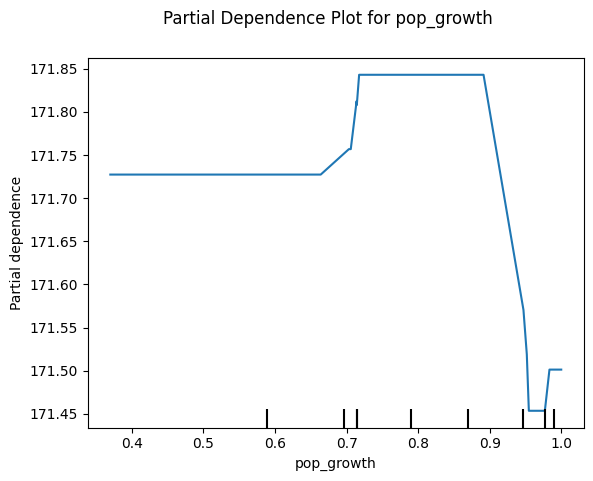

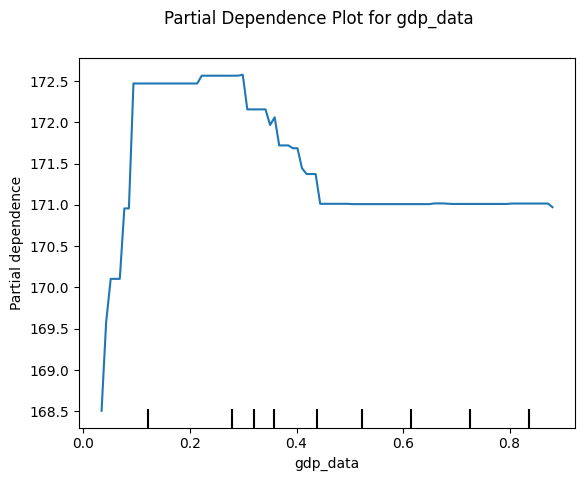

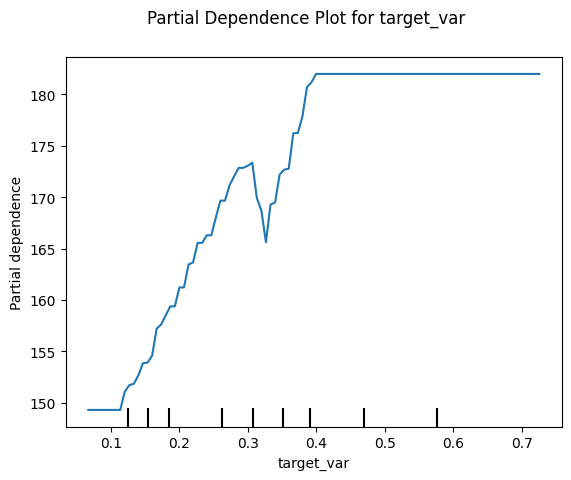

In [29]:
# Iterate through each feature and generate PDP
for feature in xtrain.columns:
    pdp_display = PartialDependenceDisplay.from_estimator(
        best_xgb_model, xtrain, features=[feature])
    pdp_display.figure_.suptitle(f'Partial Dependence Plot for {feature}')
    pdp_display.figure_.show()